In [ ]:
# Requirements
!pip install tensorflow_datasets flax jax optax tqdm netket imgaug==0.2.6

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp
import jax
import flax
import netket as nk
import jax.numpy as jnp
from jax.experimental import stax
import optax
from flax.training import train_state  # Useful dataclass to keep train state
from functools import partial
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

### Utility Functions

In [ ]:
def show_img(img, ax=None, title=None):
  """Shows a single image.
  
  Must be stored as a 3d-tensor where the last dimension is 1 channel (greyscale)
  """
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[..., 0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

##Setting up the dataset


In [ ]:
#import
ds_builder = tfds.builder('mnist')
ds_builder.download_and_prepare()
train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
# Normalize
train_ds['image'] = jnp.float32(train_ds['image']) / 255.
test_ds['image'] = jnp.float32(test_ds['image']) / 255.
print("dataset keys:", train_ds.keys())
print(f"The training dataset has shape: {train_ds['image'].shape} and dtype {train_ds['image'].dtype}")
print(f"The test     dataset has shape: {test_ds['image'].shape} and dtype {train_ds['image'].dtype}")
print("")
print(f"The training labels have shape: {train_ds['label'].shape} and dtype {train_ds['label'].dtype}")
print(f"The test     labels have shape: {test_ds['label'].shape} and dtype {test_ds['label'].dtype}")
print("The mean     of the data stored in the images are: ", np.mean(train_ds['image']))
print("The variance of the data stored in the images are: ", np.var(train_ds['image']))

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


dataset keys: dict_keys(['image', 'label'])
The training dataset has shape: (60000, 28, 28, 1) and dtype float32
The test     dataset has shape: (10000, 28, 28, 1) and dtype float32

The training labels have shape: (60000,) and dtype int64
The test     labels have shape: (10000,) and dtype int64
The mean     of the data stored in the images are:  0.13066046
The variance of the data stored in the images are:  0.09493043


##Non-linearities

In [ ]:
def modRelu(z, bias): # relu(|z|+b) * (z / |z|)
    norm = jnp.abs(z)
    scale = nk.nn.relu(norm + bias) / (norm + 1e-6)
    scaled = jax.lax.complex(jnp.real(z)*scale, jnp.imag(z)*scale)
    return scaled
def complex_relu(z):
    return jnp.where(z.real > 0, z, 0)
complex_relu = jax.jit(complex_relu)
modRelu=jax.jit(modRelu)

## Define Model

In [ ]:
# You can add a fft layer here. You can have up to 2. It is better to put them at the beginning or at the end
class Model(nk.nn.Module):
  n_classes : int = 10
  @nk.nn.compact
  def __call__(self, x, train):
    #make rng for dropoutlayer
    dropout_rng = self.make_rng('dropout')

    #first convolutions 3x3 --> 32. Avgpol 2x2 stride 2x2
    x = nk.nn.Conv(features=32, kernel_size=(3, 3), dtype=complex)(x)
    x = complex_relu(x)
    x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2)) 
    
    #second convolution 3x3 -->64. Avgpol 2x2 stride 2x2
    x = nk.nn.Conv(features=64, kernel_size=(3, 3), dtype=complex)(x)
    x = flax.linen.Dropout(0.5, deterministic=not train)(x) #DROPOUT 1
    x = complex_relu(x)
    x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

    #flatten and dense
    x = x.reshape((x.shape[0], -1))
    x = nk.nn.Dense(features=256, dtype=complex)(x)
    x = complex_relu(x)

    #DROPOUT 2
    x = flax.linen.Dropout(0.5, deterministic=not train)(x) 

    #dense2 and softmax
    x = nk.nn.Dense(features=10, dtype=complex)(x)    # There are 10 classes in MNIST
    x = jnp.abs(x)
    x = nk.nn.log_softmax(x)
    return x

## Loss functions

In [ ]:
# The loss function that we will use
def cross_entropy(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [ ]:
dropout_rng, init_dropout = jax.random.split(jax.random.PRNGKey(1))


In [ ]:
def loss_fn(params, dropout_rng, images, labels):
    """
    Loss function minimised during training of the model.
    """
    logits = model.apply(params, images, rngs={'dropout' : dropout_rng}, train=True)
    return cross_entropy(logits=logits, labels=labels)

def compute_metrics(*, logits, labels):
    """
    Compute metrics of the model during training.
    
    Returns the loss and the accuracy.
    """
    loss = cross_entropy(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics

## Create the setup and training loop


In [ ]:
def create_train_state(rng, optimiser, dropout_rng):
    """Creates initial `TrainState`, holding the current parameters, state of the
    optimiser and other metadata.
    """
    # Construct the model parameters
    params = model.init({'params' : rng, 'dropout' : dropout_rng}, jnp.ones([1, 28, 28, 1]), train=True)
        
    # Package all those informations in the model state
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=optimiser)


In [ ]:
@jax.jit
def eval_metrics(params, batch, dropout_rng):
    """
    This function evaluates the metrics without training the model.
    
    Used to check the performance of the network on training and test datasets.
    """
    logits = model.apply(params, batch['image'], rngs={'dropout' : dropout_rng}, train=False)
    return compute_metrics(logits=logits, labels=batch['label'])

In [ ]:
def loss_fn2(images, params, dropout_rng, labels):
    """
    Loss function minimised during training of the model.
    """
    logits = model.apply(params, images, rngs={'dropout' : dropout_rng}, train=True)
    return cross_entropy(logits=logits, labels=labels)


In [ ]:
@jax.jit
def train_step(state, batch, dropout_rng):
    """
    Train for a single step.
    
    """
    #Make parameters the only 'free' parameter
    _loss_fn = partial(loss_fn, dropout_rng = dropout_rng, images=batch['image'], labels=batch['label'])
    # construct the function returning the loss value and gradient.
    val_grad_fn = jax.value_and_grad(_loss_fn)
    # compute loss and gradient
    loss, grads = val_grad_fn(state.params)
    grads = jax.tree_map(lambda x: x.conj(), grads) 
    # update the state parameters 
    state = state.apply_gradients(grads=grads)

    #compute the norms of the grads
    g_tot_im = 0
    g_tot_re = 0
    g_tot_diff = 0 
    for k in grads['params'].keys():
      for sub_k in grads['params'][k]:
        g_tot_re += (grads['params'][k][sub_k].real**2).sum()
        g_tot_im += (grads['params'][k][sub_k].imag**2).sum() 
        g_tot_diff += ((grads['params'][k][sub_k].real - grads['params'][k][sub_k].imag)**2).sum()

    w_tot_im = 0
    w_tot_re = 0
    w_tot_diff = 0 
    for k in state.params['params'].keys():
      for sub_k in state.params['params'][k]:
        w_tot_re += (state.params['params'][k][sub_k].real**2).sum()
        w_tot_im += (state.params['params'][k][sub_k].imag**2).sum() 
        w_tot_diff += ((state.params['params'][k][sub_k].real - state.params['params'][k][sub_k].imag)**2).sum()

    
    metrics = eval_metrics(state.params, batch, dropout_rng)

    #save the norm of the grads
    metrics['grad_re'] = g_tot_re
    metrics['grad_im'] = g_tot_im
    metrics['grad_reimdiff'] = g_tot_diff

    metrics['weight_re'] = w_tot_re
    metrics['weight_im'] = w_tot_im
    metrics['weight_reimdiff'] = w_tot_diff

    return state, metrics

In [ ]:
def train_epoch(state, train_ds, batch_size, epoch, rng, dropout_rng, *, max_steps=None):
    """Train for a single `epoch`.
    
    And epoch is composed of several steps, where every step is taken by updating
    the network parameters with a small mini-batch.
    """
    
    # total number of training images
    train_ds_size = len(train_ds['image'])
    
    # Compute how many steps are present in this epoch.
    steps_per_epoch = train_ds_size // batch_size

    # Truncate the number of steps
    if max_steps is not None:
        steps_per_epoch = min(steps_per_epoch, max_steps)

    # generate a random permutation of the indices to shuffle the training
    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))
    
    # execute the training step for every mini-batch
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch, dropout_rng)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
            for k in batch_metrics_np[0]}



    return state, epoch_metrics_np


def evaluate_model(params, test_ds, dropout_rng):
    """
    evaluate the performance of the model on the test dataset
    """
    metrics = eval_metrics(params, test_ds, dropout_rng)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

# Training model

In [ ]:
# Definition of optimiser HyperParameters
learning_rate = 0.0005
momentum = 0.9
optimiser = optax.sgd(learning_rate, momentum)
#optimiser = nk.optimizer.Adam(learning_rate)
num_epochs = 20
batch_size = 32
max_steps = 200

#define rngs
seed = 123
seed_dropout = 0
key = {'params': jax.random.PRNGKey(seed), 'dropout': jax.random.PRNGKey(seed_dropout)}

#init model
model = Model(n_classes=10)
sample_input = jnp.ones([1, 28, 28, 1])
pars = model.init(key, sample_input, train=True)

# Split the rng to get two keys, one to 'shuffle' the dataset at every iteration,
# and one to initialise the network
rng, init_rng = jax.random.split(jax.random.PRNGKey(0))

state = create_train_state(init_rng, optimiser, init_dropout)


In [ ]:
metrics = {"test_loss" : [], 
           "test_accuracy": [], 
           "train_loss":[], 
           "train_accuracy":[],
           "grad_re":[],
           "grad_im":[],
           "grad_reimdiff":[],
           "weight_re":[],
           "weight_im":[],
           "weight_reimdiff":[],
}
with tqdm(range(1, num_epochs + 1)) as pbar:
    for epoch in pbar:
        # Use a separate PRNG key to permute image data during shuffling
        rng, input_rng = jax.random.split(rng)
        dropout_rng, _ = jax.random.split(dropout_rng)
        # Run an optimization step over a training batch
        state, train_metrics = train_epoch(state, train_ds, batch_size, epoch, input_rng, dropout_rng)
        
        # Evaluate on the test set after each training epoch
        test_loss, test_accuracy = evaluate_model(state.params, test_ds, dropout_rng)
        pbar.write('train epoch: %d, loss: %.4f, accuracy: %.2f' % (epoch, train_metrics['loss'], train_metrics['accuracy'] * 100))
        pbar.write(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (epoch, test_loss, test_accuracy * 100))

        # save data
        metrics["train_loss"].append(train_metrics["loss"])
        metrics["train_accuracy"].append(train_metrics["accuracy"])
        metrics['grad_re'].append(train_metrics['grad_re'])
        metrics['grad_im'].append(train_metrics['grad_im'])
        metrics['grad_reimdiff'].append(train_metrics['grad_reimdiff'])
        metrics['weight_re'].append(train_metrics['weight_re'])
        metrics['weight_im'].append(train_metrics['weight_im'])
        metrics['weight_reimdiff'].append(train_metrics['weight_reimdiff'])
        metrics["test_loss"].append(test_loss)
        metrics["test_accuracy"].append(test_accuracy)


  0%|          | 0/20 [00:00<?, ?it/s]

train epoch: 1, loss: 0.7428, accuracy: 81.36
 test epoch: 1, loss: 0.29, accuracy: 91.73
train epoch: 2, loss: 0.2587, accuracy: 92.19
 test epoch: 2, loss: 0.21, accuracy: 93.80
train epoch: 3, loss: 0.1974, accuracy: 94.19
 test epoch: 3, loss: 0.16, accuracy: 95.41
train epoch: 4, loss: 0.1586, accuracy: 95.43
 test epoch: 4, loss: 0.14, accuracy: 95.92
train epoch: 5, loss: 0.1313, accuracy: 96.17
 test epoch: 5, loss: 0.11, accuracy: 96.64
train epoch: 6, loss: 0.1139, accuracy: 96.65
 test epoch: 6, loss: 0.10, accuracy: 97.05
train epoch: 7, loss: 0.0990, accuracy: 97.11
 test epoch: 7, loss: 0.09, accuracy: 97.26
train epoch: 8, loss: 0.0890, accuracy: 97.36
 test epoch: 8, loss: 0.08, accuracy: 97.63
train epoch: 9, loss: 0.0806, accuracy: 97.58
 test epoch: 9, loss: 0.07, accuracy: 97.88
train epoch: 10, loss: 0.0739, accuracy: 97.80
 test epoch: 10, loss: 0.07, accuracy: 98.00
train epoch: 11, loss: 0.0680, accuracy: 97.95
 test epoch: 11, loss: 0.06, accuracy: 98.10
train 

In [ ]:
len(metrics['grad_re'])

20

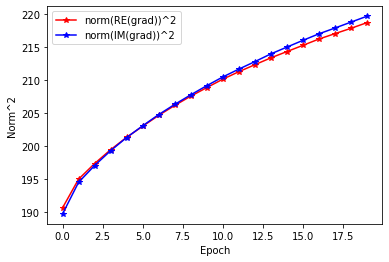

In [ ]:
epochs = [i for i in range(20)]
plt.plot(epochs, metrics['weight_re'], "*-", c='red', label='norm(RE(grad))^2')
plt.plot(epochs, metrics['weight_im'], "*-", c='blue', label='norm(IM(grad))^2')
plt.xlabel('Epoch')
plt.ylabel('Norm^2')
_ = plt.legend()

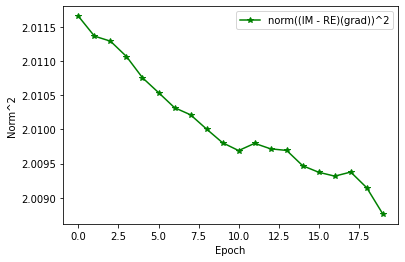

In [ ]:
metrics['weight_re'] =  np.array(metrics['weight_re'])
metrics['weight_im'] =  np.array(metrics['weight_im'])
metrics['weight_reimdiff'] =  np.array(metrics['weight_reimdiff'])

plt.plot(epochs, 2*metrics['weight_reimdiff']/(metrics['weight_re'] + metrics['weight_im']) , "*-", c='green', label='norm((IM - RE)(grad))^2')
plt.xlabel('Epoch')
plt.ylabel('Norm^2')
_ = plt.legend()

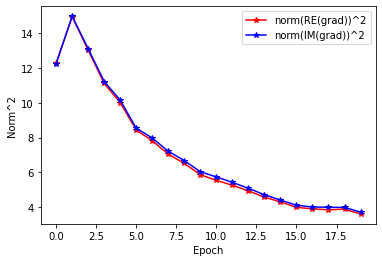

In [ ]:
epochs = [i for i in range(20)]
plt.plot(epochs, metrics['grad_re'], "*-", c='red', label='norm(RE(grad))^2')
plt.plot(epochs, metrics['grad_im'], "*-", c='blue', label='norm(IM(grad))^2')
plt.xlabel('Epoch')
plt.ylabel('Norm^2')
_ = plt.legend()

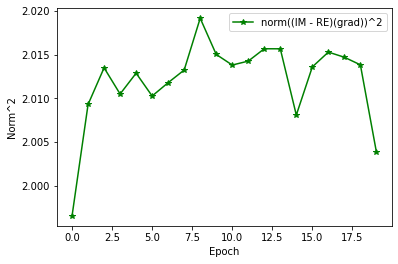

In [ ]:
metrics['grad_re'] =  np.array(metrics['grad_re'])
metrics['grad_im'] =  np.array(metrics['grad_im'])
metrics['grad_reimdiff'] =  np.array(metrics['grad_reimdiff'])

plt.plot(epochs, 2*metrics['grad_reimdiff']/(metrics['grad_re'] + metrics['grad_im']) , "*-", c='green', label='norm((IM - RE)(grad))^2')
plt.xlabel('Epoch')
plt.ylabel('Norm^2')
_ = plt.legend()

Text(0, 0.5, 'Accuracy')

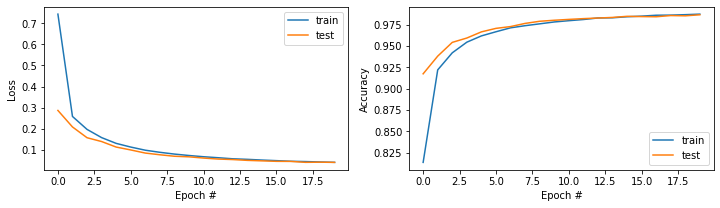

In [ ]:
#visualize losses
fig, axs = plt.subplots(1,2, figsize=(12,3))
axs[0].plot(metrics["train_loss"], label="train")
axs[0].plot(metrics["test_loss"], label="test")
axs[0].legend()
axs[0].set_xlabel("Epoch #")
axs[0].set_ylabel("Loss")


axs[1].plot(metrics["train_accuracy"], label="train")
axs[1].plot(metrics["test_accuracy"], label="test")
axs[1].legend()
axs[1].set_xlabel("Epoch #")
axs[1].set_ylabel("Accuracy")